## 
compute climatology weekly



## Climatology  (sea ice thickness)

* upload baseline climatogical means
* compute weekly time series 2023 
* compute anomalies between 2013 and 2023
* compute trends between 2013 and 2023






In [5]:
# Load packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymannkendall as mk

In [6]:
# Load 2021 raw data
ds1 = xr.open_dataset('thickness21.nc')

# Load climatological mean 19/20 for now
ds2 = xr.open_dataset('hist_clm_19_20.nc') 


### Compute monthly mean from 2021 data


In [8]:
# Compute 2021 monthly mean
ds_21_clm = ds1.groupby("time.month").mean()

# Free memory
ds1.close()

ds_21_clm

<xarray.Dataset> Size: 6MB
Dimensions:                (month: 12, rows: 361, columns: 361)
Coordinates:
  * rows                   (rows) float32 1kB -4.5e+06 -4.475e+06 ... 4.525e+06
  * columns                (columns) float32 1kB -4.525e+06 -4.5e+06 ... 4.5e+06
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cdr_sea_ice_thickness  (month, rows, columns) float32 6MB 0.0 0.0 ... 0.0

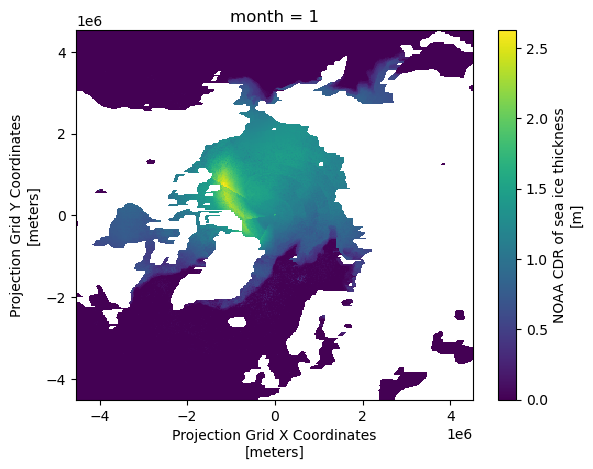

In [9]:
ds_21_clm['cdr_sea_ice_thickness'][0].plot()


# xr.plot.hist(ds_21_clm['cdr_sea_ice_thickness'][0])



### Compute Climatology (historical mean)




In [14]:
# Compute monthly mean from annualized data
clim_mean = ds2.mean(dim='year')
clim_mean

<xarray.Dataset> Size: 6MB
Dimensions:                (rows: 361, columns: 361, month: 12)
Coordinates:
  * rows                   (rows) float32 1kB -4.5e+06 -4.475e+06 ... 4.525e+06
  * columns                (columns) float32 1kB -4.525e+06 -4.5e+06 ... 4.5e+06
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cdr_sea_ice_thickness  (month, rows, columns) float32 6MB 0.0 0.0 ... 0.0

### Compute anomaly 

To understand the recent change in the sea ice thickness, we can compare the current state to the historical statistics.  Anomaly is a commonly used metric representing the difference.

For this exercise, we will use already computed histotrical median for the past 15 year period from 2006 to 2020, and we will compute the monthly anamalies.



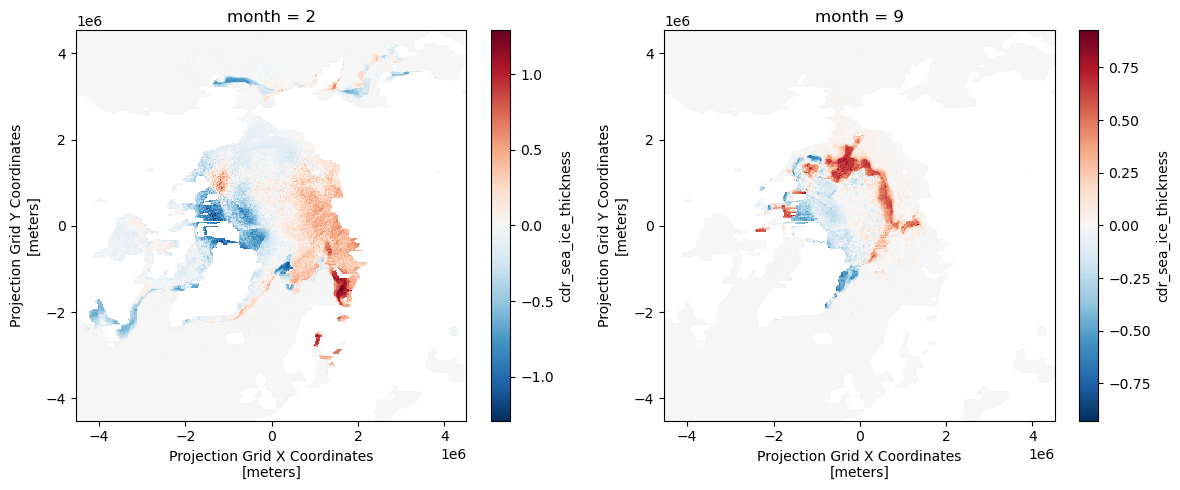

In [21]:
# Compute anomaly of 2021 from the mean data
anom_mean = ds_21_clm['cdr_sea_ice_thickness'] - clim_mean['cdr_sea_ice_thickness']

# Plot Feb and Sep anomaly
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
anom_mean[1].plot(ax=axs[0])
anom_mean[8].plot(ax=axs[1])

# Set the title
fig.suptitle('Monthly Sea ice thickness Anomalies', fontsize=13)

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()





### Compute trends and trend analysis

https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/

In [10]:
# mock dataset

import pandas as pd
import numpy as np

x = np.linspace(-10, 10, 100)   
y = np.linspace(-10, 10, 100)   
time = pd.date_range('2006-01-01', '2020-12-31', freq='A')  


test_data = np.random.uniform(0, 10, size=(len(time), len(x), len(y)))

# Create the xarray.Dataset
testds = xr.Dataset(
    {
        "test_var": (["time", "x", "y"], test_data)
    },
    coords={
        "time": time,
        "x": x,
        "y": y
    }
)

# Print the dataset
print(testds)

<xarray.Dataset> Size: 1MB
Dimensions:   (time: 15, x: 100, y: 100)
Coordinates:
  * time      (time) datetime64[ns] 120B 2006-12-31 2007-12-31 ... 2020-12-31
  * x         (x) float64 800B -10.0 -9.798 -9.596 -9.394 ... 9.596 9.798 10.0
  * y         (y) float64 800B -10.0 -9.798 -9.596 -9.394 ... 9.596 9.798 10.0
Data variables:
    test_var  (time, x, y) float64 1MB 3.806 7.892 4.749 ... 7.243 5.904 0.04563


/var/folders/g4/n09b0k3x52g3__xt52gq4kb00000gp/T/ipykernel_86994/2542920409.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  time = pd.date_range('2006-01-01', '2020-12-31', freq='A')


In [11]:



# Define a function to apply the Mann-Kendall test and return the slope
def mk_slope(data):
    result = mk.original_test(data)
    return result.slope

# Apply the function across the 'time' dimension for each pixel
slopes = xr.apply_ufunc(
    mk_slope,                # The function to apply
    testds,                    # The data variable
    input_core_dims=[['time']],  # The dimension over which to apply the function
    vectorize=True,          # Vectorize to apply across all pixels
    dask='parallelized',     # Enable parallel processing if using Dask
    output_dtypes=[float]    # The output type (float for slope)
)

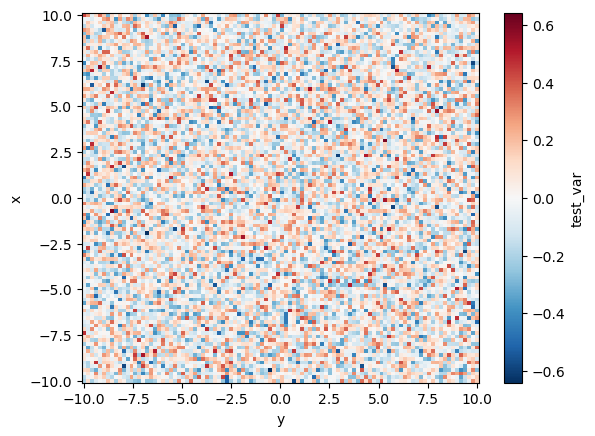

In [28]:
slopes['test_var'].plot()
plt.show()






